# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [2]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [3]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [4]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [5]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,CLASS
count,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,0.333764,0.200042,0.251736,0.365734,0.160780,0.402400,0.032250
std,1.025813,1.136427,1.101461,0.988616,1.157123,0.939678,0.176674
min,-0.784415,-0.452501,-0.591631,-0.859553,-0.377866,-0.945723,0.000000
25%,-0.145333,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,0.000000
50%,0.111790,-0.271133,-0.005571,0.550163,-0.377866,0.845975,0.000000
75%,0.508993,0.219887,0.400163,1.027382,0.387549,1.132403,0.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [5]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [6]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [7]:
def oversampling_replacement(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

def oversampling_SMOTE(data):
    '''Faz o oversampling usando o algoritmo SMOTE
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    sm = SMOTE(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = sm.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = sm.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

def random_undersampling(data):
    '''Faz o undersampling randomicamente
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    randomunder = RandomUnderSampler(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = randomunder.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = randomunder.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [10]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

### Separando entrada de saida

In [11]:
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
join_c = join_class(grupos)
over = random_undersampling(join_c)
print (len(over[0]), len(over[1]), len(over[2]))

7592 253
3796 1898 1898 126 63 64
252 126 1962


In [12]:
X_train = over[0][:,:-1]
y_train = over[0][:,-1]

X_validation = over[1][:,:-1]
y_validation = over[1][:,-1]

X_test = over[2][:,:-1]
y_test = over[2][:,-1]

# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({0.0: 126, 1.0: 126})
Counter({0.0: 63, 1.0: 63})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções e constantes auxiliares.

In [14]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history, name):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Error Curves: ' + str(name), xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history, name):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Accuracy Curves: '+ str(name), xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()
    

In [15]:
learnRate = 0.001
graficoName = "undersampling random, lr=0.001, rede="

## RNA 1 (10)

In [18]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=300)

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=0,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

In [36]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1184/1962 [=================>............] - ETA: 0s[0.096703590587859975, 0.87614678905158472]


<IPython.core.display.Javascript object>


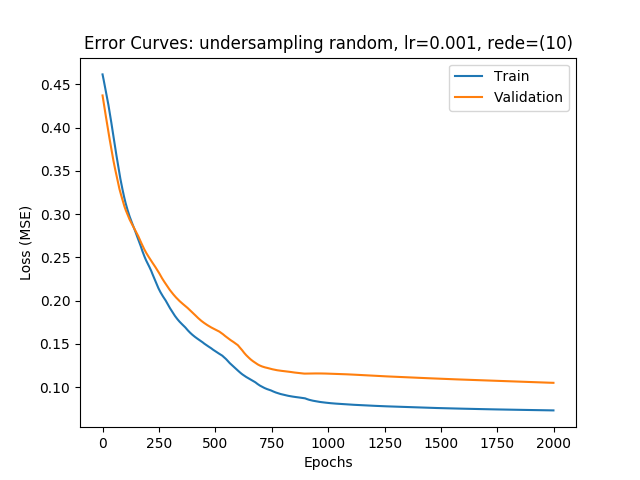

<IPython.core.display.Javascript object>


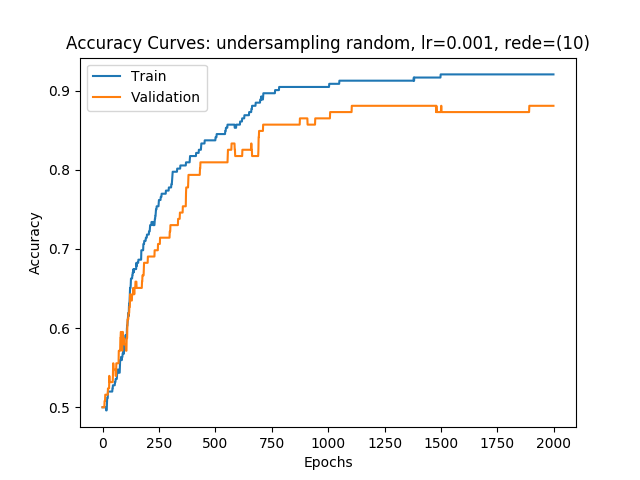

Matriz de confusão
[[1705  193]
 [   6   58]]

Train Loss:       0.0731
Validation Loss:  0.1049
Accuracy:         0.8986
MSE:              0.1014
AUROC:            0.9365


In [19]:
plot_training_error_curves(history, graficoName + "(10)")
plot_training_acc_curves(history, graficoName + "(10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 2 (20)

In [22]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=300)

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=0,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

In [39]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1312/1962 [===================>..........] - ETA: 0s[0.049268450006979318, 0.93577981639224328]


<IPython.core.display.Javascript object>


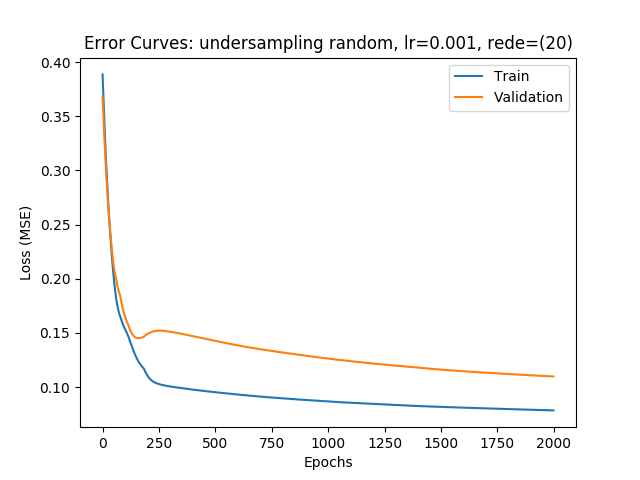

<IPython.core.display.Javascript object>


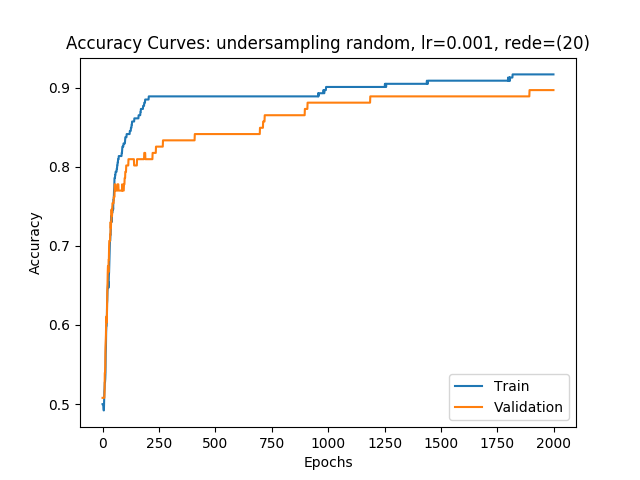

Matriz de confusão
[[1722  176]
 [   8   56]]

Train Loss:       0.0785
Validation Loss:  0.1098
Accuracy:         0.9062
MSE:              0.0938
AUROC:            0.9375


In [23]:
plot_training_error_curves(history, graficoName + "(20)")
plot_training_acc_curves(history, graficoName + "(20)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 3 (10, 15)

In [26]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(15, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=300)

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=0,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

In [42]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1472/1962 [=====================>........] - ETA: 0s[0.05201185193903949, 0.93781855237593348]


<IPython.core.display.Javascript object>


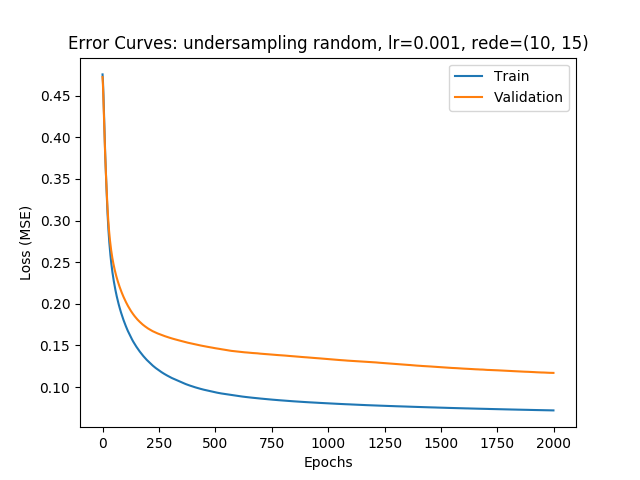

<IPython.core.display.Javascript object>


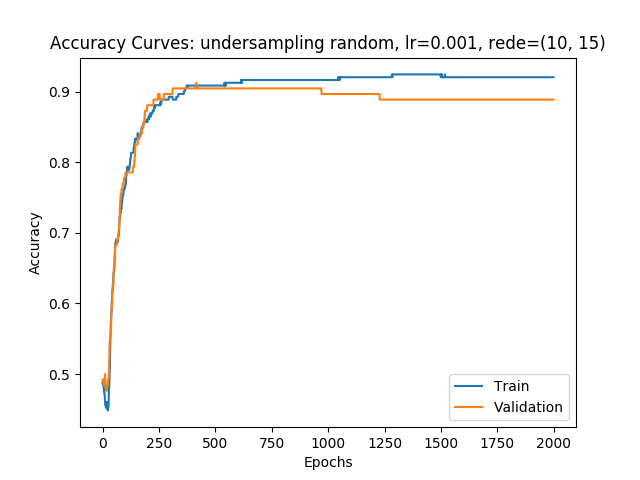

Matriz de confusão
[[1748  150]
 [   6   58]]

Train Loss:       0.0719
Validation Loss:  0.1169
Accuracy:         0.9205
MSE:              0.0795
AUROC:            0.9386


In [27]:
plot_training_error_curves(history, graficoName + "(10, 15)")
plot_training_acc_curves(history, graficoName + "(10, 15)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 4 (20, 10)

In [30]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(10, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=300)

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=0,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

In [45]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1408/1962 [====================>.........] - ETA: 0s[0.080024987914875736, 0.90519877681916883]


<IPython.core.display.Javascript object>


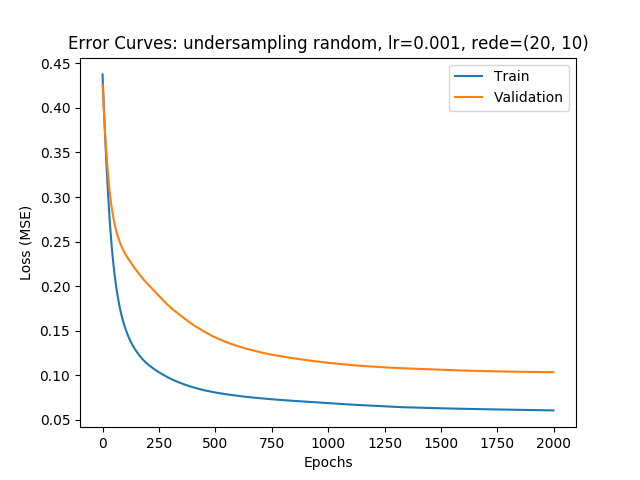

<IPython.core.display.Javascript object>


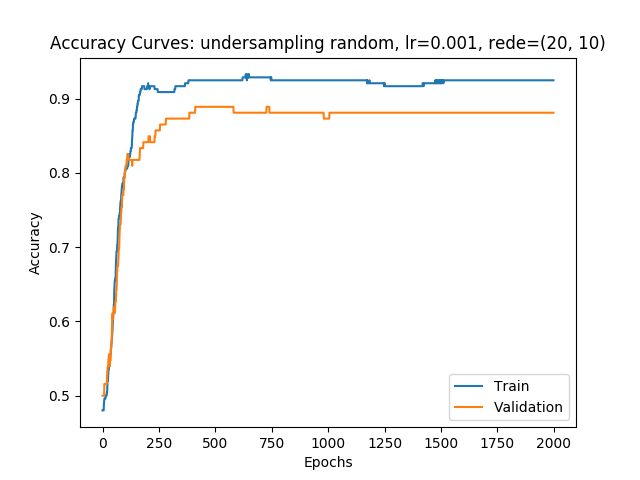

Matriz de confusão
[[1729  169]
 [   7   57]]

Train Loss:       0.0606
Validation Loss:  0.1035
Accuracy:         0.9103
MSE:              0.0897
AUROC:            0.9219


In [31]:
plot_training_error_curves(history, graficoName + "(20, 10)")
plot_training_acc_curves(history, graficoName + "(20, 10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 5 (2)

In [91]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(2, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.4012 - acc: 0.4921 - val_loss: 0.3508 - val_acc: 0.4921
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.3089 - acc: 0.5119 - val_loss: 0.2538 - val_acc: 0.6111
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.2271 - acc: 0.6865 - val_loss: 0.1899 - val_acc: 0.7540
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.1743 - acc: 0.7817 - val_loss: 0.1556 - val_acc: 0.8016
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.1423 - acc: 0.8175 - val_loss: 0.1446 - val_acc: 0.8095
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.1309 - acc: 0.8452 - val_loss: 0.1519 - val_acc: 0.8413
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.1219 - acc: 0.8651 - val_loss: 0.1506 - val_acc: 0.8730
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.1192 - acc

252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.9048 - val_loss: 0.1473 - val_acc: 0.8651
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0933 - acc: 0.9048 - val_loss: 0.1464 - val_acc: 0.8651
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0931 - acc: 0.8968 - val_loss: 0.1455 - val_acc: 0.8571
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0925 - acc: 0.8968 - val_loss: 0.1436 - val_acc: 0.8571
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0930 - acc: 0.8929 - val_loss: 0.1420 - val_acc: 0.8571
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8968 - val_loss: 0.1402 - val_acc: 0.8651
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0913 - acc: 0.8968 - val_loss: 0.1355 - val_acc: 0.8651
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8929 - val_loss: 0.1384 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1155 - val_acc: 0.8651
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1188 - val_acc: 0.8571
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9008 - val_loss: 0.1170 - val_acc: 0.8571
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9008 - val_loss: 0.1145 - val_acc: 0.8651
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1192 - val_acc: 0.8651
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9008 - val_loss: 0.1174 - val_acc: 0.8571
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1168 - val_acc: 0.8651
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9008 - val_loss: 0.1191 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1179 - val_acc: 0.8651
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1175 - val_acc: 0.8571
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9008 - val_loss: 0.1196 - val_acc: 0.8571
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1159 - val_acc: 0.8651
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9008 - val_loss: 0.1183 - val_acc: 0.8571
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1208 - val_acc: 0.8651
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1178 - val_acc: 0.8571
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1163 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9048 - val_loss: 0.1188 - val_acc: 0.8651
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9008 - val_loss: 0.1179 - val_acc: 0.8571
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9008 - val_loss: 0.1196 - val_acc: 0.8571
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1184 - val_acc: 0.8651
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9048 - val_loss: 0.1158 - val_acc: 0.8651
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9008 - val_loss: 0.1196 - val_acc: 0.8571
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1202 - val_acc: 0.8651
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1168 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1171 - val_acc: 0.8651
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1182 - val_acc: 0.8571
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1168 - val_acc: 0.8571
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1175 - val_acc: 0.8651
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9008 - val_loss: 0.1195 - val_acc: 0.8651
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9048 - val_loss: 0.1184 - val_acc: 0.8571
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9008 - val_loss: 0.1164 - val_acc: 0.8651
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9008 - val_loss: 0.1176 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9008 - val_loss: 0.1175 - val_acc: 0.8651
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9008 - val_loss: 0.1174 - val_acc: 0.8651
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9008 - val_loss: 0.1202 - val_acc: 0.8571
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9008 - val_loss: 0.1183 - val_acc: 0.8651
Epoch 773/2000
252/252 [==============================] - ETA: 0s - loss: 0.0962 - acc: 0.875 - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1170 - val_acc: 0.8571
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1166 - val_acc: 0.8571
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1206 - val_acc: 0.8651
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.900

252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1178 - val_acc: 0.8651
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1201 - val_acc: 0.8651
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1159 - val_acc: 0.8571
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1160 - val_acc: 0.8571
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9008 - val_loss: 0.1184 - val_acc: 0.8651
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9008 - val_loss: 0.1208 - val_acc: 0.8651
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1159 - val_acc: 0.8651
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1185 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9008 - val_loss: 0.1182 - val_acc: 0.8571
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9048 - val_loss: 0.1149 - val_acc: 0.8651
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9008 - val_loss: 0.1181 - val_acc: 0.8651
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1171 - val_acc: 0.8651
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1173 - val_acc: 0.8571
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9008 - val_loss: 0.1172 - val_acc: 0.8651
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1209 - val_acc: 0.8571
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9008 - val_loss: 0.1166 - val_acc:

252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1156 - val_acc: 0.8571
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9048 - val_loss: 0.1184 - val_acc: 0.8571
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9008 - val_loss: 0.1188 - val_acc: 0.8651
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1156 - val_acc: 0.8571
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1181 - val_acc: 0.8651
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1167 - val_acc: 0.8651
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1186 - val_acc: 0.8651
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1155 - val_acc:

252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1181 - val_acc: 0.8571
Epoch 1280/2000
252/252 [==============================] - ETA: 0s - loss: 0.0682 - acc: 0.906 - 0s - loss: 0.0788 - acc: 0.9008 - val_loss: 0.1203 - val_acc: 0.8651
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1178 - val_acc: 0.8651
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9008 - val_loss: 0.1175 - val_acc: 0.8651
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9008 - val_loss: 0.1169 - val_acc: 0.8651
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1176 - val_acc: 0.8651
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1175 - val_acc: 0.8651
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc

252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9048 - val_loss: 0.1180 - val_acc: 0.8651
Epoch 1407/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1162 - val_acc: 0.8651
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9008 - val_loss: 0.1198 - val_acc: 0.8651
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9008 - val_loss: 0.1179 - val_acc: 0.8651
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1173 - val_acc: 0.8651
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1171 - val_acc: 0.8651
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1160 - val_acc: 0.8651
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1180 - val_acc:

252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1187 - val_acc: 0.8571
Epoch 1535/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1164 - val_acc: 0.8651
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9008 - val_loss: 0.1182 - val_acc: 0.8651
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9048 - val_loss: 0.1194 - val_acc: 0.8651
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9008 - val_loss: 0.1160 - val_acc: 0.8651
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9008 - val_loss: 0.1178 - val_acc: 0.8571
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9048 - val_loss: 0.1193 - val_acc: 0.8571
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9008 - val_loss: 0.1151 - val_acc:

252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1174 - val_acc: 0.8651
Epoch 1663/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9008 - val_loss: 0.1183 - val_acc: 0.8571
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1186 - val_acc: 0.8571
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1147 - val_acc: 0.8651
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1179 - val_acc: 0.8651
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1208 - val_acc: 0.8571
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9008 - val_loss: 0.1174 - val_acc: 0.8651
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1183 - val_acc:

252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1164 - val_acc: 0.8651
Epoch 1790/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1147 - val_acc: 0.8651
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9048 - val_loss: 0.1160 - val_acc: 0.8571
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1193 - val_acc: 0.8651
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1178 - val_acc: 0.8651
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9008 - val_loss: 0.1185 - val_acc: 0.8651
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1161 - val_acc: 0.8651
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1168 - val_acc:

252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9008 - val_loss: 0.1204 - val_acc: 0.8651
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1188 - val_acc: 0.8651
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1153 - val_acc: 0.8651
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1161 - val_acc: 0.8651
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1188 - val_acc: 0.8571
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1165 - val_acc: 0.8651
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9008 - val_loss: 0.1183 - val_acc: 0.8571
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1176 - val_acc:

In [92]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.06902084823519325, 0.87512742087746254]


/home/opcinove/.virtualenvs/python3.6env/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


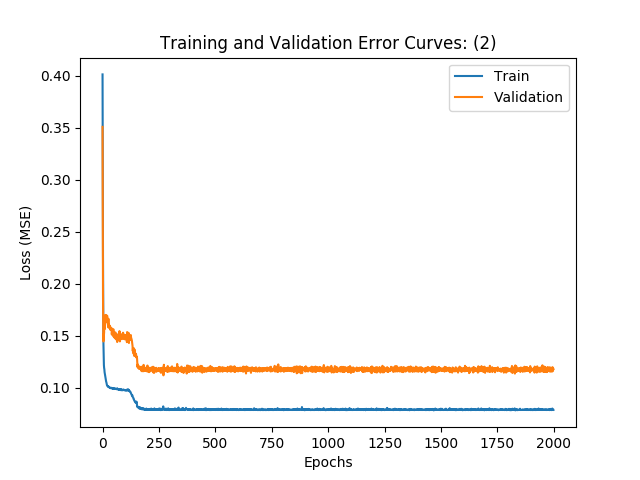

<IPython.core.display.Javascript object>


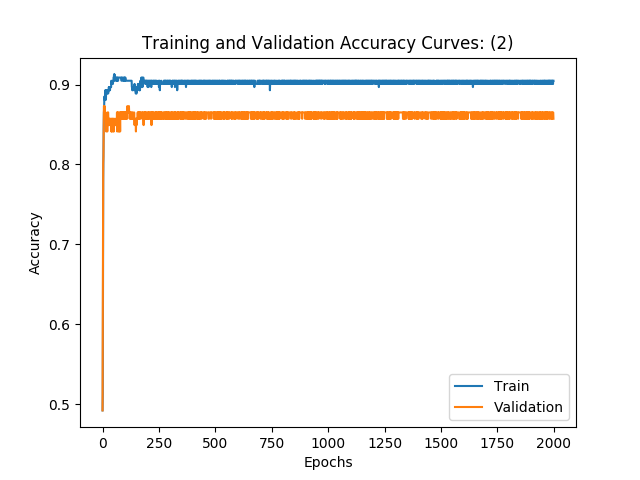

Matriz de confusão
[[1660  238]
 [   6   58]]

Train Loss:       0.0808
Validation Loss:  0.1121
Accuracy:         0.8756
MSE:              0.1244
AUROC:            0.9348


In [93]:
plot_training_error_curves(history, "(2)")
plot_training_acc_curves(history, "(2)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 6 (4)

In [94]:
# Aq## RNA 5 (2)ui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(4, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.5802 - acc: 0.3611 - val_loss: 0.5293 - val_acc: 0.4048
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.5169 - acc: 0.4802 - val_loss: 0.5031 - val_acc: 0.5000
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.5015 - acc: 0.5000 - val_loss: 0.4988 - val_acc: 0.5000
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.5001 - acc: 0.5000 - val_loss: 0.4990 - val_acc: 0.5000
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.4999 - acc: 0.5000 - val_loss: 0.4997 - val_acc: 0.5000
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.4997 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.4996 - acc: 0.5000 - val_loss: 0.5002 - val_acc: 0.5000
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.4994 - acc

252/252 [==============================] - 0s - loss: 0.0732 - acc: 0.9127 - val_loss: 0.1131 - val_acc: 0.8651
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9127 - val_loss: 0.1140 - val_acc: 0.8651
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9127 - val_loss: 0.1138 - val_acc: 0.8571
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0732 - acc: 0.9127 - val_loss: 0.1149 - val_acc: 0.8571
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0727 - acc: 0.9087 - val_loss: 0.1160 - val_acc: 0.8571
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9127 - val_loss: 0.1132 - val_acc: 0.8571
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.9087 - val_loss: 0.1136 - val_acc: 0.8571
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0722 - acc: 0.9087 - val_loss: 0.1151 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9246 - val_loss: 0.1272 - val_acc: 0.8651
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9325 - val_loss: 0.1265 - val_acc: 0.8651
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9286 - val_loss: 0.1314 - val_acc: 0.8651
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9286 - val_loss: 0.1268 - val_acc: 0.8651
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9286 - val_loss: 0.1291 - val_acc: 0.8651
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9325 - val_loss: 0.1275 - val_acc: 0.8571
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9286 - val_loss: 0.1283 - val_acc: 0.8651
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9325 - val_loss: 0.1297 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0668 - acc: 0.9325 - val_loss: 0.1299 - val_acc: 0.8651
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9325 - val_loss: 0.1282 - val_acc: 0.8571
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9286 - val_loss: 0.1288 - val_acc: 0.8651
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9325 - val_loss: 0.1280 - val_acc: 0.8651
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9286 - val_loss: 0.1308 - val_acc: 0.8571
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9286 - val_loss: 0.1268 - val_acc: 0.8651
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9325 - val_loss: 0.1271 - val_acc: 0.8651
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9325 - val_loss: 0.1331 - val_acc: 0.8492

252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9286 - val_loss: 0.1272 - val_acc: 0.8571
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0678 - acc: 0.9246 - val_loss: 0.1283 - val_acc: 0.8492
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.9246 - val_loss: 0.1311 - val_acc: 0.8651
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9246 - val_loss: 0.1237 - val_acc: 0.8730
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0678 - acc: 0.9325 - val_loss: 0.1278 - val_acc: 0.8571
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0669 - acc: 0.9286 - val_loss: 0.1293 - val_acc: 0.8730
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0666 - acc: 0.9286 - val_loss: 0.1238 - val_acc: 0.8571
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0677 - acc: 0.9246 - val_loss: 0.1273 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0658 - acc: 0.9286 - val_loss: 0.1275 - val_acc: 0.8651
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9286 - val_loss: 0.1286 - val_acc: 0.8651
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1287 - val_acc: 0.8651
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9286 - val_loss: 0.1256 - val_acc: 0.8651
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1286 - val_acc: 0.8571
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0669 - acc: 0.9286 - val_loss: 0.1293 - val_acc: 0.8571
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9286 - val_loss: 0.1269 - val_acc: 0.8651
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9286 - val_loss: 0.1260 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9365 - val_loss: 0.1243 - val_acc: 0.8571
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9325 - val_loss: 0.1292 - val_acc: 0.8651
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9286 - val_loss: 0.1307 - val_acc: 0.8651
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9325 - val_loss: 0.1269 - val_acc: 0.8651
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9286 - val_loss: 0.1279 - val_acc: 0.8651
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9286 - val_loss: 0.1315 - val_acc: 0.8651
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0668 - acc: 0.9286 - val_loss: 0.1280 - val_acc: 0.8651
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9325 - val_loss: 0.1246 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9286 - val_loss: 0.1293 - val_acc: 0.8571
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9286 - val_loss: 0.1268 - val_acc: 0.8571
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0678 - acc: 0.9286 - val_loss: 0.1287 - val_acc: 0.8651
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9286 - val_loss: 0.1288 - val_acc: 0.8651
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1260 - val_acc: 0.8651
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9286 - val_loss: 0.1284 - val_acc: 0.8571
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9286 - val_loss: 0.1322 - val_acc: 0.8571
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9286 - val_loss: 0.1267 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0658 - acc: 0.9286 - val_loss: 0.1278 - val_acc: 0.8651
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0658 - acc: 0.9325 - val_loss: 0.1284 - val_acc: 0.8651
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9325 - val_loss: 0.1289 - val_acc: 0.8571
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1294 - val_acc: 0.8651
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9325 - val_loss: 0.1288 - val_acc: 0.8651
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9325 - val_loss: 0.1271 - val_acc: 0.8651
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9325 - val_loss: 0.1296 - val_acc: 0.8651
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9286 - val_loss: 0.1269 - val_acc:

252/252 [==============================] - 0s - loss: 0.0658 - acc: 0.9286 - val_loss: 0.1263 - val_acc: 0.8571
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9325 - val_loss: 0.1309 - val_acc: 0.8651
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9325 - val_loss: 0.1297 - val_acc: 0.8571
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0680 - acc: 0.9286 - val_loss: 0.1304 - val_acc: 0.8651
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0680 - acc: 0.9246 - val_loss: 0.1275 - val_acc: 0.8492
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0668 - acc: 0.9286 - val_loss: 0.1304 - val_acc: 0.8651
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9286 - val_loss: 0.1260 - val_acc: 0.8651
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.0666 - acc: 0.9325 - val_loss: 0.1292 - val_acc:

252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9286 - val_loss: 0.1295 - val_acc: 0.8651
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9286 - val_loss: 0.1271 - val_acc: 0.8571
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0680 - acc: 0.9286 - val_loss: 0.1275 - val_acc: 0.8651
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9286 - val_loss: 0.1282 - val_acc: 0.8651
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0669 - acc: 0.9286 - val_loss: 0.1276 - val_acc: 0.8651
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9286 - val_loss: 0.1281 - val_acc: 0.8651
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9365 - val_loss: 0.1278 - val_acc: 0.8651
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9286 - val_loss: 0.1295 - val_acc:

252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9325 - val_loss: 0.1301 - val_acc: 0.8651
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9286 - val_loss: 0.1284 - val_acc: 0.8651
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9325 - val_loss: 0.1278 - val_acc: 0.8651
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9365 - val_loss: 0.1281 - val_acc: 0.8651
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0658 - acc: 0.9286 - val_loss: 0.1303 - val_acc: 0.8651
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9286 - val_loss: 0.1273 - val_acc: 0.8651
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0666 - acc: 0.9286 - val_loss: 0.1285 - val_acc: 0.8651
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9286 - val_loss: 0.1311 - val_acc:

252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9286 - val_loss: 0.1273 - val_acc: 0.8651
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9365 - val_loss: 0.1285 - val_acc: 0.8651
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9325 - val_loss: 0.1285 - val_acc: 0.8651
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9286 - val_loss: 0.1318 - val_acc: 0.8730
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9286 - val_loss: 0.1256 - val_acc: 0.8651
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0679 - acc: 0.9286 - val_loss: 0.1307 - val_acc: 0.8651
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9286 - val_loss: 0.1271 - val_acc: 0.8492
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9325 - val_loss: 0.1279 - val_acc:

252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9325 - val_loss: 0.1268 - val_acc: 0.8651
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9286 - val_loss: 0.1300 - val_acc: 0.8651
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9325 - val_loss: 0.1298 - val_acc: 0.8651
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0657 - acc: 0.9325 - val_loss: 0.1277 - val_acc: 0.8651
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9286 - val_loss: 0.1304 - val_acc: 0.8651
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9325 - val_loss: 0.1274 - val_acc: 0.8571
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0658 - acc: 0.9325 - val_loss: 0.1271 - val_acc: 0.8651
Epoch 1670/2000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9325 - val_loss: 0.1293 - val_acc:

252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9246 - val_loss: 0.1344 - val_acc: 0.8730
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9286 - val_loss: 0.1271 - val_acc: 0.8571
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9286 - val_loss: 0.1294 - val_acc: 0.8651
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0666 - acc: 0.9286 - val_loss: 0.1286 - val_acc: 0.8651
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9286 - val_loss: 0.1296 - val_acc: 0.8651
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9286 - val_loss: 0.1264 - val_acc: 0.8571
Epoch 1797/2000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9286 - val_loss: 0.1320 - val_acc: 0.8651
Epoch 1798/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9286 - val_loss: 0.1289 - val_acc:

252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9325 - val_loss: 0.1295 - val_acc: 0.8651
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0666 - acc: 0.9286 - val_loss: 0.1294 - val_acc: 0.8651
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9325 - val_loss: 0.1282 - val_acc: 0.8651
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1306 - val_acc: 0.8651
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9286 - val_loss: 0.1279 - val_acc: 0.8651
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1319 - val_acc: 0.8651
Epoch 1925/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9286 - val_loss: 0.1261 - val_acc: 0.8571
Epoch 1926/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9325 - val_loss: 0.1285 - val_acc:

In [95]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1962/1962 [==============================] - 0s     
[0.073499742242204791, 0.89908256868582137]


/home/opcinove/.virtualenvs/python3.6env/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


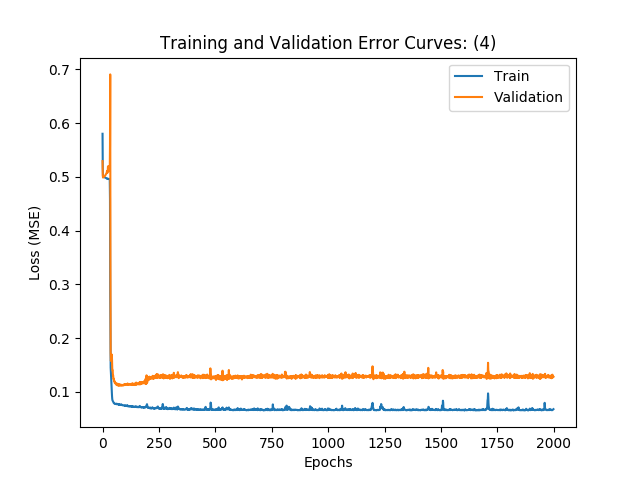

<IPython.core.display.Javascript object>


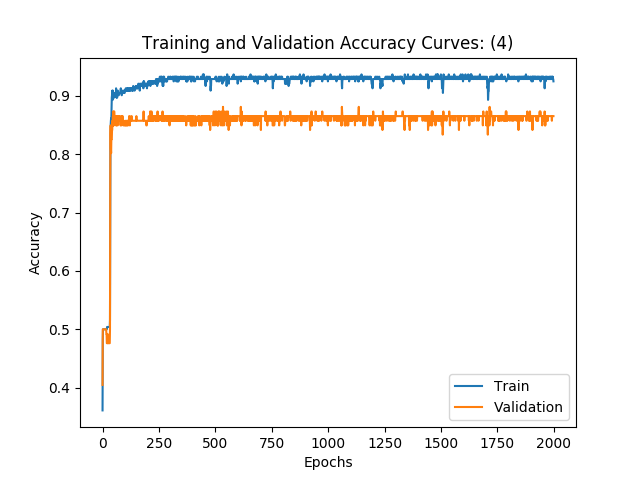

Matriz de confusão
[[1709  189]
 [   8   56]]

Train Loss:       0.0770
Validation Loss:  0.1116
Accuracy:         0.8996
MSE:              0.1004
AUROC:            0.9144


In [96]:
plot_training_error_curves(history, "(4)")
plot_training_acc_curves(history, "(4)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))